# 1 BTP-Bond Analysis

In [1]:
import pandas as pd
import numpy as mp
import matplotlib.pyplot as plt
import seaborn as sns

start_date = pd.to_datetime("2025-03-10")
end_date = pd.to_datetime("2025-04-30")
event_date = pd.to_datetime("2025-04-04")

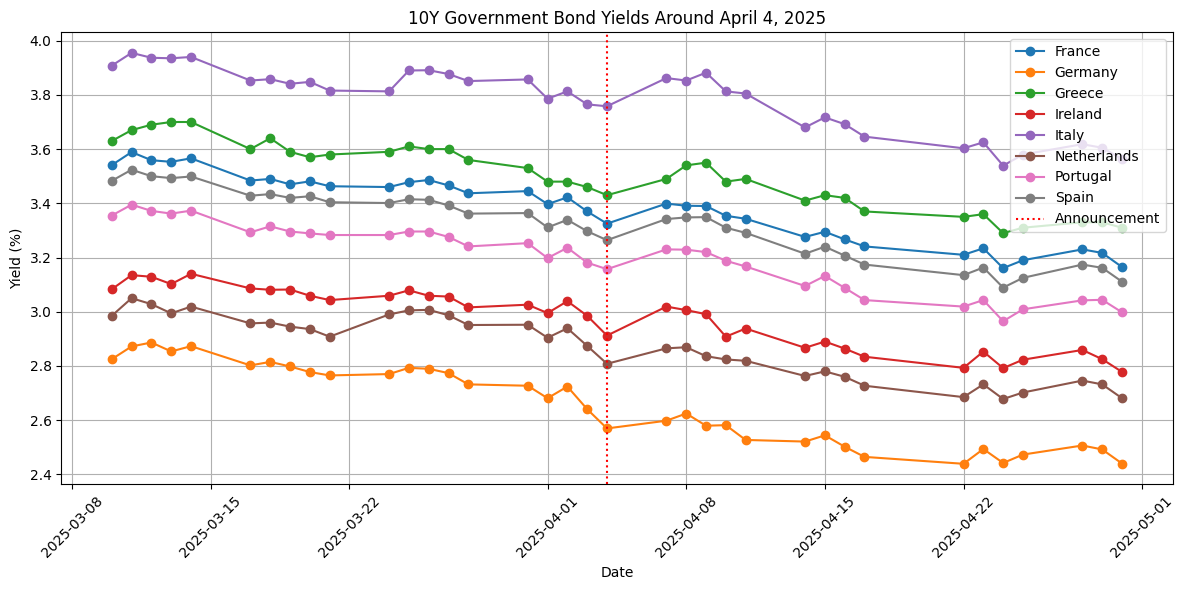

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the bond files and their new column names
countries = [
    "France", "Germany", "Greece", "Ireland",
    "Italy", "Netherlands", "Portugal", "Spain"
]
files = {
    f"{country} 10-Year Bond Yield Historical Data.csv": f"{country}"
    for country in countries
}


# Load and process each bond dataset
dfs = []
for file, col_name in files.items():
    df = pd.read_csv('../data/Bond/' + file)
    df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
    df = df[['Date', 'Price']].rename(columns={'Price': col_name})
    dfs.append(df)

# Merge all DataFrames on 'Date'
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs)

# Filter to event window
window_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

# Plot yields
plt.figure(figsize=(12, 6))
for col in files.values():
    plt.plot(window_df['Date'], window_df[col], label=col, marker='o')

plt.axvline(event_date, color='red', linestyle=':', label='Announcement')
plt.title('10Y Government Bond Yields Around April 4, 2025')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


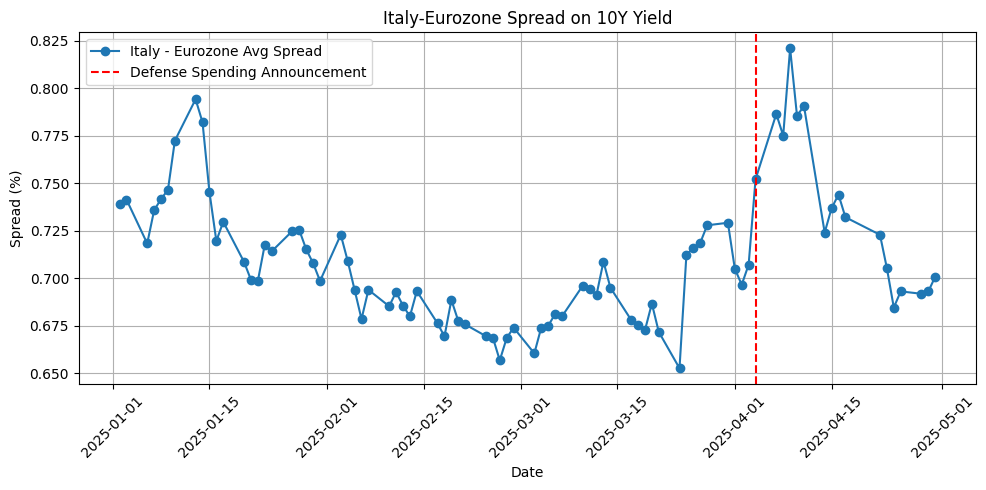

In [3]:
# Define which countries to include in the Euro average
eurozone_core = ["Germany", "France", "Spain", "Netherlands", "Portugal", "Ireland"]

# Calculate Eurozone average yield
merged_df["Euro_Avg"] = merged_df[eurozone_core].mean(axis=1)

# Calculate Italy vs Eurozone spread
merged_df["Italy_Euro_Spread"] = merged_df["Italy"] - merged_df["Euro_Avg"]

# Plot Spread over time
plt.figure(figsize=(10, 5))
plt.plot(merged_df["Date"], merged_df["Italy_Euro_Spread"], label="Italy - Eurozone Avg Spread", marker='o')
plt.axvline(event_date, color='red', linestyle='--', label="Defense Spending Announcement")
plt.title("Italy-Eurozone Spread on 10Y Yield")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2 GDELT Analysis

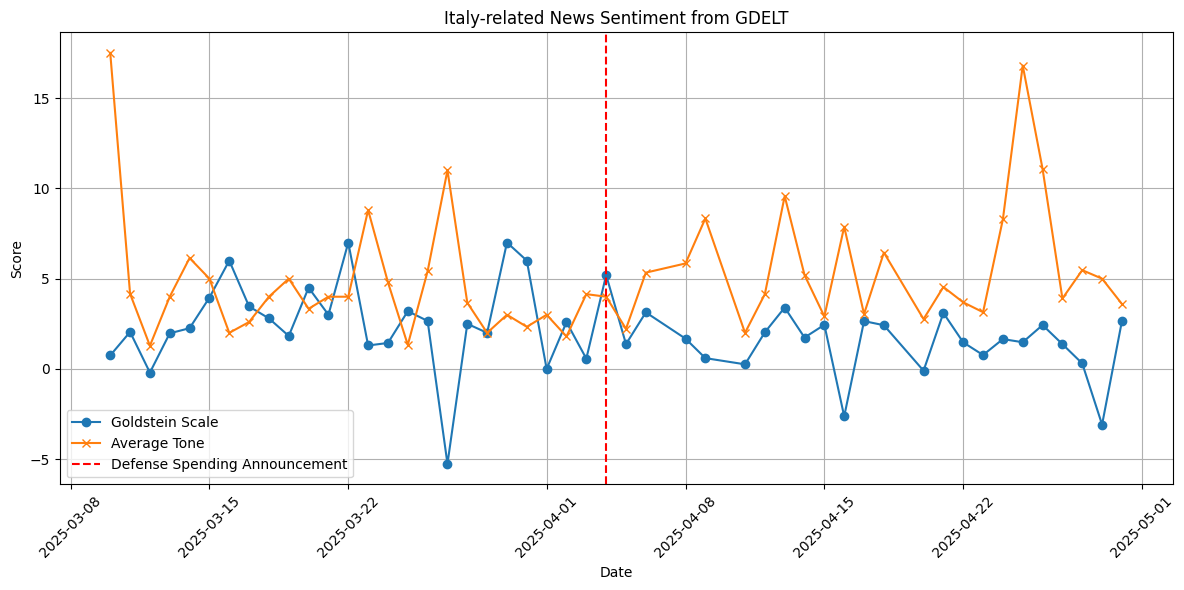

In [4]:
import pandas as pd
import os
import zipfile
from io import TextIOWrapper
import matplotlib.pyplot as plt

# Define folder containing all .zip GDELT files
folder_path = "../data/gdelt_zips/"  # make sure your .zip files are here
all_dfs = []

# Loop through all .zip files in folder
for filename in os.listdir(folder_path):
    if filename.endswith(".zip"):
        zip_path = os.path.join(folder_path, filename)
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_name = zip_file.namelist()[0]  # GDELT zip usually contains 1 CSV
            with zip_file.open(csv_name) as f:
                df = pd.read_csv(TextIOWrapper(f, 'utf-8'), sep='\t', header=None, low_memory=False)
                
                # Rename columns
                df.columns = [f"col_{i}" for i in range(df.shape[1])]
                
                # Filter for Italy (Actor2CountryCode == ITA)
                df_italy = df[df["col_17"] == "ITA"]
                
                if not df_italy.empty:
                    df_italy = df_italy[["col_1", "col_30", "col_31"]]
                    df_italy.columns = ["SQLDATE", "GoldsteinScale", "AvgTone"]
                    df_italy["SQLDATE"] = pd.to_datetime(df_italy["SQLDATE"], format="%Y%m%d", errors="coerce")
                    
                    # Optional: filter for date range (you can adjust this)
                    df_italy = df_italy[
                        (df_italy["SQLDATE"] >= start_date) &
                        (df_italy["SQLDATE"] <= end_date)
                    ]
                    
                    all_dfs.append(df_italy)

# Combine all Italy-related records
combined_df = pd.concat(all_dfs, ignore_index=True)

# Group by day and compute average tone and goldstein
daily_avg = combined_df.groupby("SQLDATE")[["GoldsteinScale", "AvgTone"]].mean().reset_index()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(daily_avg["SQLDATE"], daily_avg["GoldsteinScale"], label="Goldstein Scale", marker='o')
plt.plot(daily_avg["SQLDATE"], daily_avg["AvgTone"], label="Average Tone", marker='x')
plt.axvline(pd.to_datetime("2025-04-04"), color='red', linestyle='--', label="Defense Spending Announcement")
plt.title("Italy-related News Sentiment from GDELT")
plt.xlabel("Date")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3 Euro Stoxx Analysis

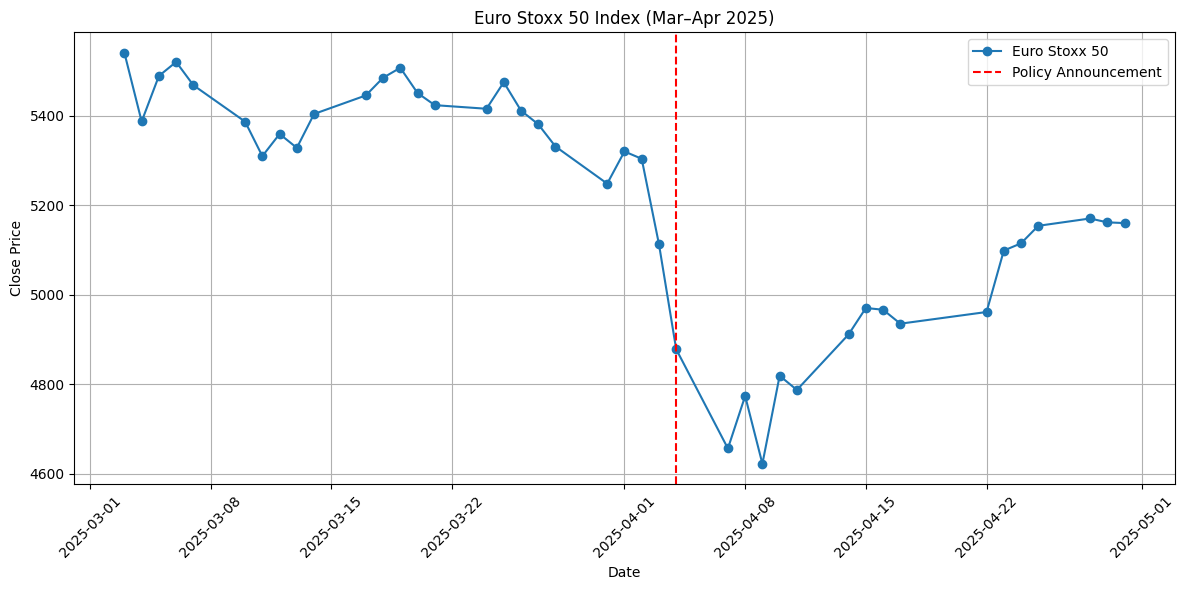

In [5]:
euro_df = pd.read_csv("../data/Euro_Stoxx_50.csv")

# Convert date and sort
euro_df["Date"] = pd.to_datetime(euro_df["Date"])
euro_df = euro_df.sort_values("Date")

plt.figure(figsize=(12, 6))
plt.plot(euro_df["Date"], euro_df["EuroStoxx50_Close"], marker='o', label="Euro Stoxx 50")
plt.axvline(pd.to_datetime("2025-04-04"), color='red', linestyle='--', label="Policy Announcement")
plt.title("Euro Stoxx 50 Index (Mar–Apr 2025)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4 Machine Learning

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assume merged_df and daily_avg are already defined in previous steps
# Merge Euro Stoxx 50 data into ml_df
ml_df = pd.merge(merged_df, daily_avg.rename(columns={"SQLDATE": "Date"}), on="Date", how="inner")
ml_df = pd.merge(ml_df, euro_df, on="Date", how="left")

# Step 2: Feature selection and standardization
features = ["Italy", "Italy_Euro_Spread", "GoldsteinScale", "AvgTone", "EuroStoxx50_Close"]
X = ml_df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
ml_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: PCA projection
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
ml_df['PC1'] = components[:, 0]
ml_df['PC2'] = components[:, 1]

ml_df.groupby("Cluster")[["Italy", "Italy_Euro_Spread", "GoldsteinScale", "AvgTone"]].mean()

,Italy,Italy_Euro_Spread,GoldsteinScale,AvgTone
Cluster,,,,
0,3.737333,0.755426,1.490995,4.765650
1,3.798560,0.696107,1.596631,5.272866


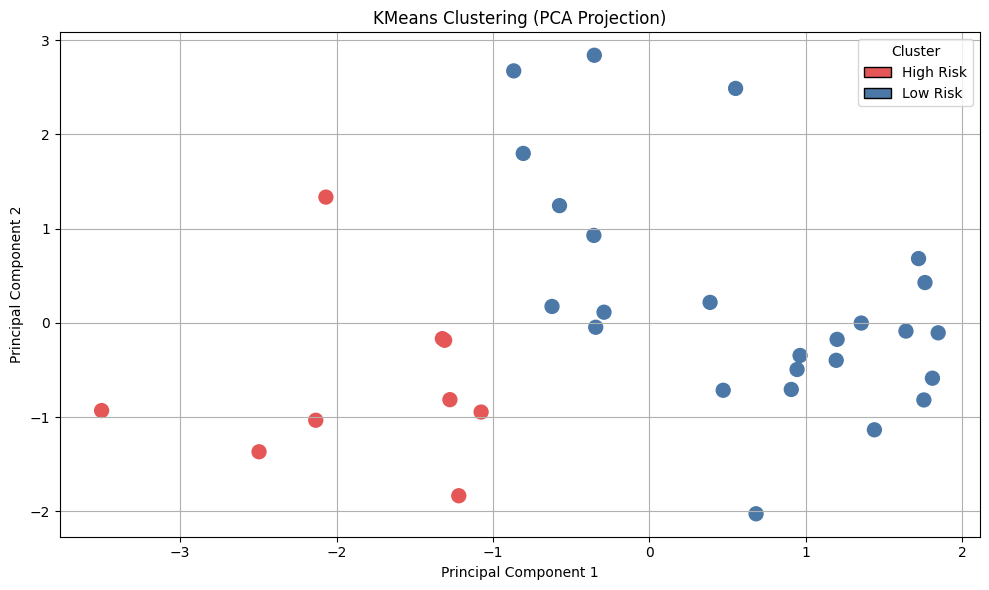

In [7]:
import matplotlib.colors as mcolors

# Create a custom color map: Cluster 0 (High Risk) -> red, Cluster 1 (Low Risk) -> blue
cmap = mcolors.ListedColormap(["#E45756", "#4C78A8"])

# Step 5: PCA scatter plot with fixed colors and labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    ml_df['PC1'], ml_df['PC2'], 
    c=ml_df['Cluster'], 
    cmap=cmap, 
    s=100
)

# Custom legend labels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#E45756', edgecolor='black', label='High Risk'),
    Patch(facecolor='#4C78A8', edgecolor='black', label='Low Risk')
]

plt.title("KMeans Clustering (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(handles=legend_elements, title="Cluster")
plt.tight_layout()
plt.show()

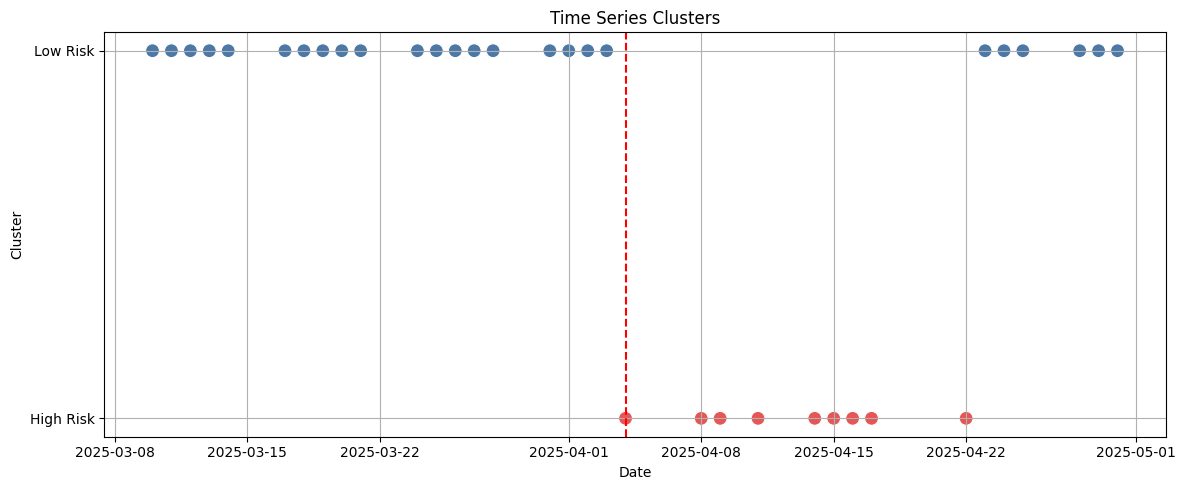

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color mapping
custom_palette = {
    0: "#E45756",  # High Risk
    1: "#4C78A8"   # Low Risk
}

plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=ml_df,
    x="Date",
    y="Cluster",
    hue="Cluster",
    palette=custom_palette,
    s=100
)

plt.axvline(pd.to_datetime("2025-04-04"), color="red", linestyle="--", label="Policy Announcement")
plt.yticks([0, 1], ["High Risk", "Low Risk"])
plt.title("Time Series Clusters")
plt.xlabel("Date")
plt.ylabel("Cluster")
plt.grid(True)
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()